In [ ]:
!pip install ucimlrepo

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance, plot_tree

# Procesamiento de Datos:

In [190]:
from ucimlrepo import fetch_ucirepo

air_quality = fetch_ucirepo(id=360)
Xair = air_quality.data.features
yair = air_quality.data.targets

In [191]:
# Crear el DataFrame con todas las características
df_total= air_quality.data.features

#Seleccionar las columnas específicas con las que se va a trabajar
df = df_total[['Date', 'Time', 'C6H6(GT)', 'T', 'RH']]

# Cambiar el nombre de la variable C6H6(GT)
df = df.rename(columns={'C6H6(GT)': 'C6H6'})

In [192]:
#Crear columna Datetime combinada
df['Datetime'] = df['Date'] + ' ' + df['Time']

# Intentar convertir a datetime y capturar el error
# En lugar de poner format='%d/%m/%Y %H:%M:%S' poner dayfirst=False para que infiera automaticamente el formato
try:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)
except ValueError as e:
    print(f"Error al convertir fechas: {e}")

# Mostrars las filas que no se convirtieron correctamente
print(df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()])

# Mostrar las filas que no se convirtieron correctamente para asegurarnos que se convirtió buen
invalid_dates = df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()]
print("Filas con fechas no válidas:")
print(invalid_dates)

Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []
Filas con fechas no válidas:
Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []


In [193]:
# Establecer la columna datetime como índice, eliminar las columnas Date y Time
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [194]:
# Reemplazar los valores -200 en la columna T con NaN
df['C6H6'] = df['C6H6'].replace(-200, pd.NA)
df['T'] = df['T'].replace(-200, pd.NA)
df['RH'] = df['RH'].replace(-200, pd.NA)

# Aplicar forward fill para reemplazar los valores NaN
df['C6H6'].ffill(inplace=True)
df['T'].ffill(inplace=True)
df['RH'].ffill(inplace=True)

In [195]:
new_order = ['T', 'C6H6', 'RH']
df = df[new_order]
print(df)

                        T  C6H6    RH
Datetime                             
2004-03-10 18:00:00  13.6  11.9  48.9
2004-03-10 19:00:00  13.3   9.4  47.7
2004-03-10 20:00:00  11.9   9.0  54.0
2004-03-10 21:00:00  11.0   9.2  60.0
2004-03-10 22:00:00  11.2   6.5  59.6
...                   ...   ...   ...
2005-04-04 10:00:00  21.9  13.5  29.3
2005-04-04 11:00:00  24.3  11.4  23.7
2005-04-04 12:00:00  26.9  12.4  18.3
2005-04-04 13:00:00  28.3   9.5  13.5
2005-04-04 14:00:00  28.5  11.9  13.1

[9357 rows x 3 columns]


In [ ]:
#Sólo la columna T
df = df[['T']]
print(df)

                        T
Datetime                 
2004-03-10 18:00:00  13.6
2004-03-10 19:00:00  13.3
2004-03-10 20:00:00  11.9
2004-03-10 21:00:00  11.0
2004-03-10 22:00:00  11.2
...                   ...
2005-04-04 10:00:00  21.9
2005-04-04 11:00:00  24.3
2005-04-04 12:00:00  26.9
2005-04-04 13:00:00  28.3
2005-04-04 14:00:00  28.5

[9357 rows x 1 columns]


# Modelo ensamble XGBoost

*Separación de train y test*

In [ ]:
# Train/Test  90% y 10% se toma esta división para después poder usar el mismo % en las 5 grupos de cross validation
df_T_train = df['T'].iloc[:round(len(df['T'])*.9)]
df_T_test = df['T'].iloc[round(len(df['T'])*.9):]
print(len(df_T_train), len(df_T_test))

8421 936


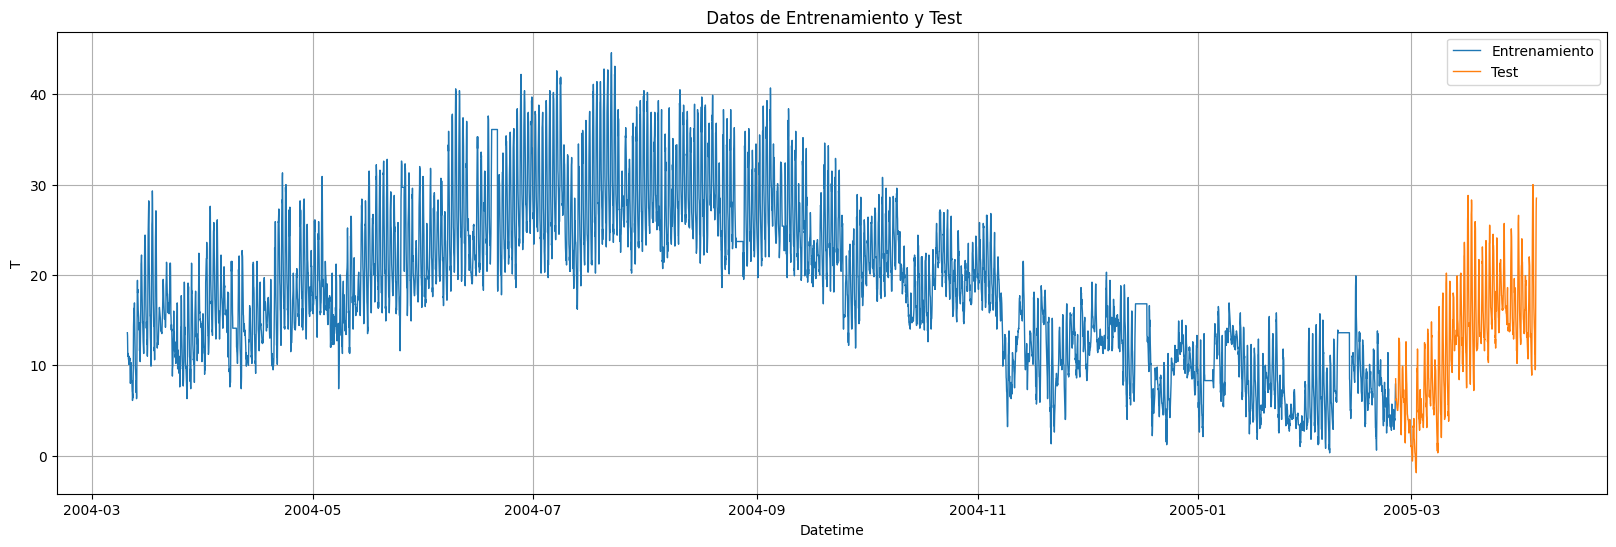

In [ ]:
# Gráficos train y test
plt.figure(figsize=(20, 6))

plt.plot(df_T_train, label='Entrenamiento', linestyle='-', linewidth=1)
plt.plot(df_T_test, label='Test', linestyle='-', linewidth=1)

plt.title(' Datos de Entrenamiento y Test')
plt.xlabel('Datetime')
plt.ylabel('T')

plt.legend()
plt.grid(True)
plt.show()

*Cross Validation*

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
#Se usa la función TimeSeriesSplit para la separación de los datos para el cross validatio
tss = TimeSeriesSplit(n_splits=5, test_size=936, gap=24) #Se deja un gap de24 hs entre cada unos de los 5 grupos de datos
df = df.sort_index() # ordena las filas del DataFrame df según los valores del índice

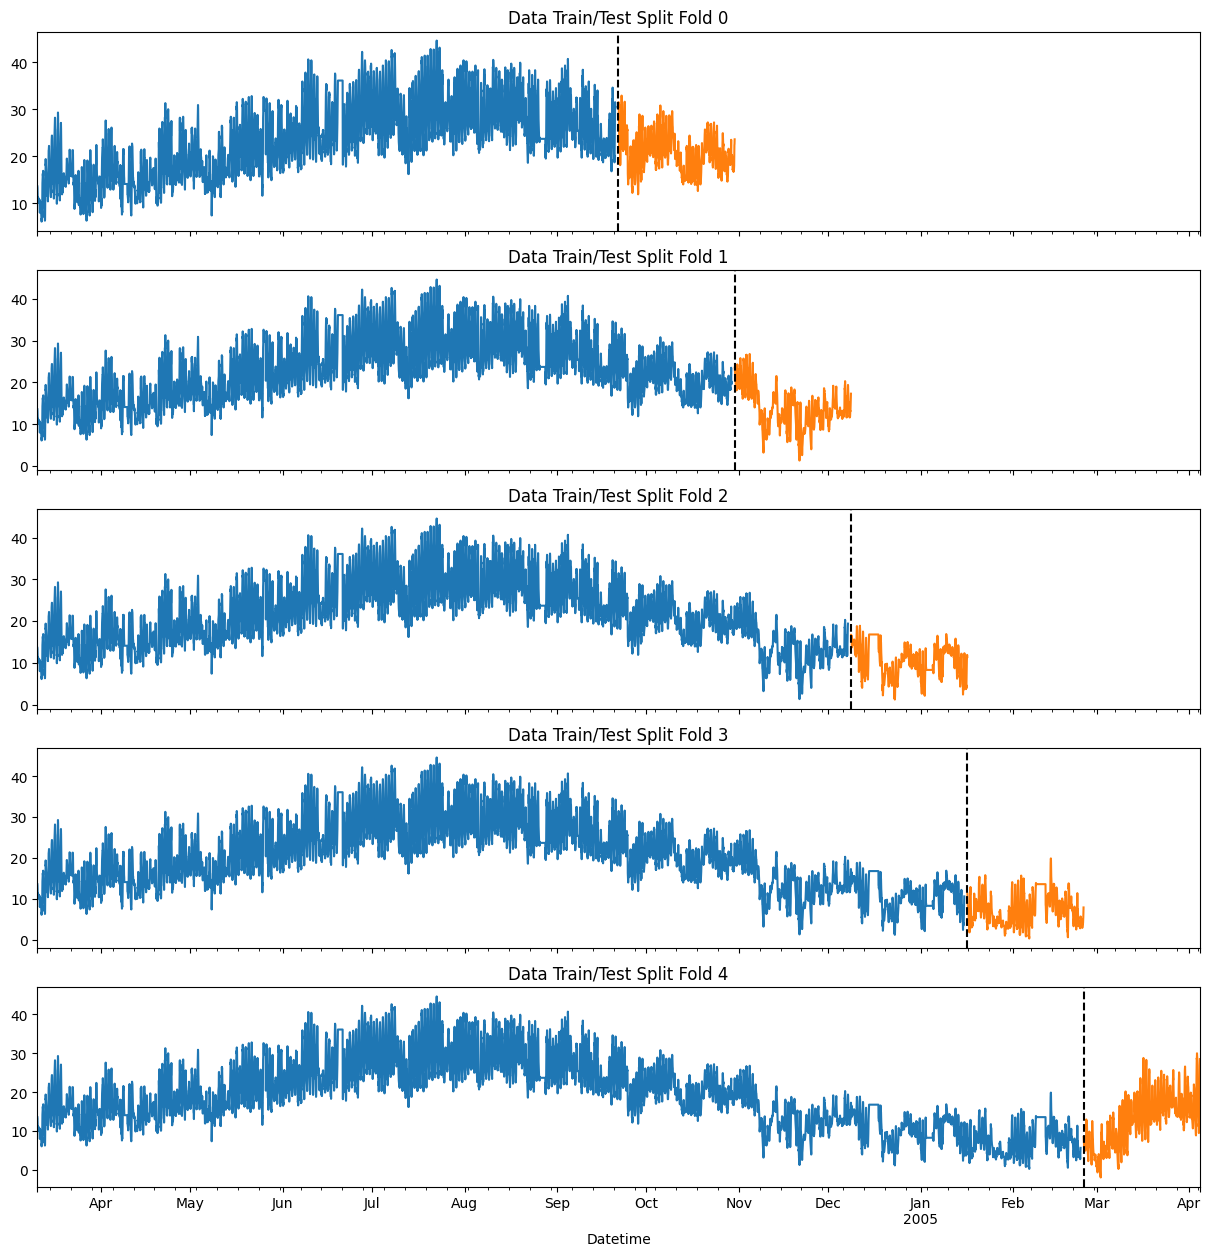

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df['T']):
    train = df['T'].iloc[train_idx]
    val = df['T'].iloc[val_idx]
    train.plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    val.plot(ax=axs[fold],label='Val Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
#Cross validation manteniendo el orden temporal de los datos

for i, (train_index, test_index) in enumerate(tss.split(df)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[   0    1    2 ... 4650 4651 4652]
  Test:  index=[4677 4678 4679 4680 4681 4682 4683 4684 4685 4686 4687 4688 4689 4690
 4691 4692 4693 4694 4695 4696 4697 4698 4699 4700 4701 4702 4703 4704
 4705 4706 4707 4708 4709 4710 4711 4712 4713 4714 4715 4716 4717 4718
 4719 4720 4721 4722 4723 4724 4725 4726 4727 4728 4729 4730 4731 4732
 4733 4734 4735 4736 4737 4738 4739 4740 4741 4742 4743 4744 4745 4746
 4747 4748 4749 4750 4751 4752 4753 4754 4755 4756 4757 4758 4759 4760
 4761 4762 4763 4764 4765 4766 4767 4768 4769 4770 4771 4772 4773 4774
 4775 4776 4777 4778 4779 4780 4781 4782 4783 4784 4785 4786 4787 4788
 4789 4790 4791 4792 4793 4794 4795 4796 4797 4798 4799 4800 4801 4802
 4803 4804 4805 4806 4807 4808 4809 4810 4811 4812 4813 4814 4815 4816
 4817 4818 4819 4820 4821 4822 4823 4824 4825 4826 4827 4828 4829 4830
 4831 4832 4833 4834 4835 4836 4837 4838 4839 4840 4841 4842 4843 4844
 4845 4846 4847 4848 4849 4850 4851 4852 4853 4854 4855 4856 4857 4858
 48

*Creación de variables y lags*

In [ ]:
#Creación de features basadas en el índice tiempo para captar las estacionalidades

def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour #almacena en una columna nueva la hora
    df['dayofweek'] = df.index.dayofweek #almacena en una columna nueva el día de la semana
    df['quarter'] = df.index.quarter #trimestre
    df['month'] = df.index.month #mes
    df['year'] = df.index.year #año
    df['dayofyear'] = df.index.dayofyear #dia del año: de 1 a 365
    df['dayofmonth'] = df.index.day #día del mes: de 1 a 31
    df['weekofyear'] = df.index.isocalendar().week #día de la semana 1 a 52
    return df

In [ ]:
df = create_features(df)
print(df.head(5))

                        T  C6H6    RH  hour  dayofweek  quarter  month  year  \
Datetime                                                                       
2004-03-10 18:00:00  13.6  11.9  48.9    18          2        1      3  2004   
2004-03-10 19:00:00  13.3   9.4  47.7    19          2        1      3  2004   
2004-03-10 20:00:00  11.9   9.0  54.0    20          2        1      3  2004   
2004-03-10 21:00:00  11.0   9.2  60.0    21          2        1      3  2004   
2004-03-10 22:00:00  11.2   6.5  59.6    22          2        1      3  2004   

                     dayofyear  dayofmonth  weekofyear  
Datetime                                                
2004-03-10 18:00:00         70          10          11  
2004-03-10 19:00:00         70          10          11  
2004-03-10 20:00:00         70          10          11  
2004-03-10 21:00:00         70          10          11  
2004-03-10 22:00:00         70          10          11  


In [ ]:
#Agregado de lags ayuda a captar la estacionaliad
def add_lags(df):
    df['lag_24'] = df['T'].shift(24) #estacionalidad de 1 día
    df['lag_168'] = df['T'].shift(168) #estacionaliad de 1 semana
    df['lag_720'] = df['T'].shift(720) #estacionalidad de 1 mes
    return df

# Aplicar la función al DataFrame
df = add_lags(df)
print(df.tail(5))

                        T  C6H6    RH  hour  dayofweek  quarter  month  year  \
Datetime                                                                       
2005-04-04 10:00:00  21.9  13.5  29.3    10          0        2      4  2005   
2005-04-04 11:00:00  24.3  11.4  23.7    11          0        2      4  2005   
2005-04-04 12:00:00  26.9  12.4  18.3    12          0        2      4  2005   
2005-04-04 13:00:00  28.3   9.5  13.5    13          0        2      4  2005   
2005-04-04 14:00:00  28.5  11.9  13.1    14          0        2      4  2005   

                     dayofyear  dayofmonth  weekofyear  lag_24  lag_168  \
Datetime                                                                  
2005-04-04 10:00:00         94           4          14    21.1     17.8   
2005-04-04 11:00:00         94           4          14    24.0     20.8   
2005-04-04 12:00:00         94           4          14    26.5     21.6   
2005-04-04 13:00:00         94           4          14    28.7  

*Entrenamiento*

In [ ]:
df = df.sort_index()

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=936, gap=24)

In [ ]:
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [ ]:
import xgboost as xgb
print(xgb.__version__)

2.1.1


In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):   #se usa cross validation
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag_24','lag_168','lag_720']
    TARGET = 'T'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #modelado basado en árboles
                           n_estimators=1000, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:squarederror', #Para hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01)

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)   # Muestra información de entrenamiento cada 100 iteraciones

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

[0]	validation_0-rmse:7.64299	validation_1-rmse:4.88643
[100]	validation_0-rmse:4.05666	validation_1-rmse:3.41892
[200]	validation_0-rmse:3.09328	validation_1-rmse:3.15583
[300]	validation_0-rmse:2.81225	validation_1-rmse:3.10123
[400]	validation_0-rmse:2.68580	validation_1-rmse:3.00189
[500]	validation_0-rmse:2.60666	validation_1-rmse:2.95410
[600]	validation_0-rmse:2.54679	validation_1-rmse:2.97066
[700]	validation_0-rmse:2.50115	validation_1-rmse:2.99385
[800]	validation_0-rmse:2.45624	validation_1-rmse:2.99481
[900]	validation_0-rmse:2.41894	validation_1-rmse:3.00647
[999]	validation_0-rmse:2.37441	validation_1-rmse:2.99924
[0]	validation_0-rmse:7.23938	validation_1-rmse:10.37351
[100]	validation_0-rmse:3.91165	validation_1-rmse:6.12543
[200]	validation_0-rmse:3.03013	validation_1-rmse:5.06624
[300]	validation_0-rmse:2.76711	validation_1-rmse:4.74033
[400]	validation_0-rmse:2.66616	validation_1-rmse:4.64805
[500]	validation_0-rmse:2.59841	validation_1-rmse:4.74331
[600]	validation_

In [ ]:
#promedio de la puntuacion en cada folds
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3.5762
Fold scores:[2.9992397145319503, 5.199747751626445, 3.528923573839853, 3.32176856017328, 2.8311096057971077]


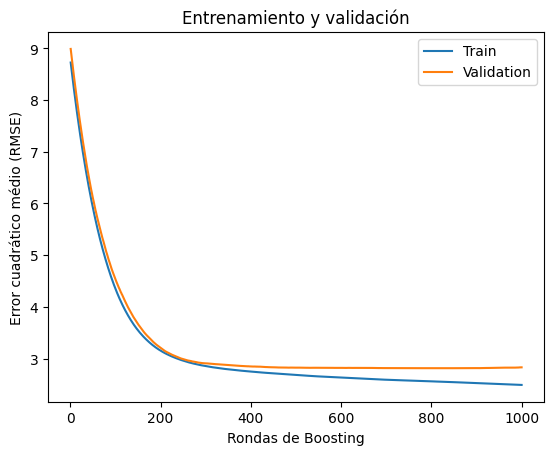

In [ ]:
# Curva train y validacion según la métrica RMSE
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Rondas de Boosting')
plt.ylabel('Error cuadrático médio (RMSE)')
plt.title('Entrenamiento y validación')
plt.legend()
plt.show()

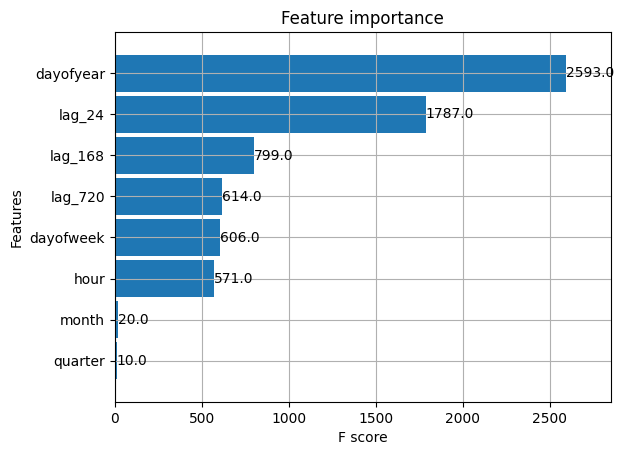

In [ ]:
#Importancia de las variables
_ = plot_importance(reg, height=0.9)

In [ ]:
y_pred = reg.predict(X_val)
y_pred

array([ 6.3300376,  7.1254697,  6.368042 ,  5.5168867,  5.1793065,
        5.24996  ,  5.0902023,  5.275631 ,  5.275631 ,  4.2571597,
        4.9995413,  4.2571597,  4.216577 ,  4.216577 ,  4.216577 ,
        4.216577 ,  4.216577 ,  4.216577 ,  4.6741843,  5.567416 ,
        5.7161727,  6.361012 ,  6.879929 ,  8.687466 ,  9.22933  ,
        8.696618 ,  7.5305758,  7.365291 ,  6.827409 ,  6.6835327,
        6.333511 ,  6.1280613,  6.1280613,  4.943434 ,  4.943434 ,
        4.8263717,  4.785789 ,  4.785789 ,  4.785789 ,  4.902851 ,
        4.902851 ,  4.902851 ,  5.517915 ,  8.029042 ,  9.215162 ,
       11.797975 , 10.031978 , 10.8604765, 11.511323 , 11.511323 ,
       11.22776  ,  9.375383 ,  8.817928 ,  7.5731626,  7.1578736,
        6.546514 ,  6.117916 ,  4.8461223,  4.733058 ,  4.6512923,
        4.5377293,  4.6395683,  4.6924753,  4.709111 ,  5.4635825,
        5.7814827,  6.3016324,  8.810608 ,  9.13505  ,  8.9650135,
        8.983593 ,  8.983593 ,  8.983593 ,  8.828632 ,  8.0679

In [ ]:
val['prediction'] = reg.predict(X_val)
val['prediction']

<ipython-input-93-45d02612bb7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


,prediction
Datetime,
2005-02-24 15:00:00,6.133223
2005-02-24 16:00:00,6.060047
2005-02-24 17:00:00,5.353911
2005-02-24 18:00:00,5.131666
2005-02-24 19:00:00,4.667797
...,...
2005-04-04 10:00:00,21.742996
2005-04-04 11:00:00,27.271534
2005-04-04 12:00:00,28.275154


In [ ]:
val

,T,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_24,lag_168,lag_720,prediction
Datetime,,,,,,,,,,,,,
2005-02-24 15:00:00,8.5,15,3,1,2,2005,55,24,8,5.6,8.9,4.5,6.330038
2005-02-24 16:00:00,7.6,16,3,1,2,2005,55,24,8,5.4,9.0,5.1,7.125470
2005-02-24 17:00:00,7.2,17,3,1,2,2005,55,24,8,4.9,9.3,5.0,6.368042
2005-02-24 18:00:00,6.7,18,3,1,2,2005,55,24,8,4.8,8.4,4.3,5.516887
2005-02-24 19:00:00,6.1,19,3,1,2,2005,55,24,8,4.8,7.6,4.3,5.179307
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,21.9,10,0,2,4,2005,94,4,14,21.1,17.8,10.0,19.137823
2005-04-04 11:00:00,24.3,11,0,2,4,2005,94,4,14,24.0,20.8,13.0,23.363390
2005-04-04 12:00:00,26.9,12,0,2,4,2005,94,4,14,26.5,21.6,14.0,24.455635


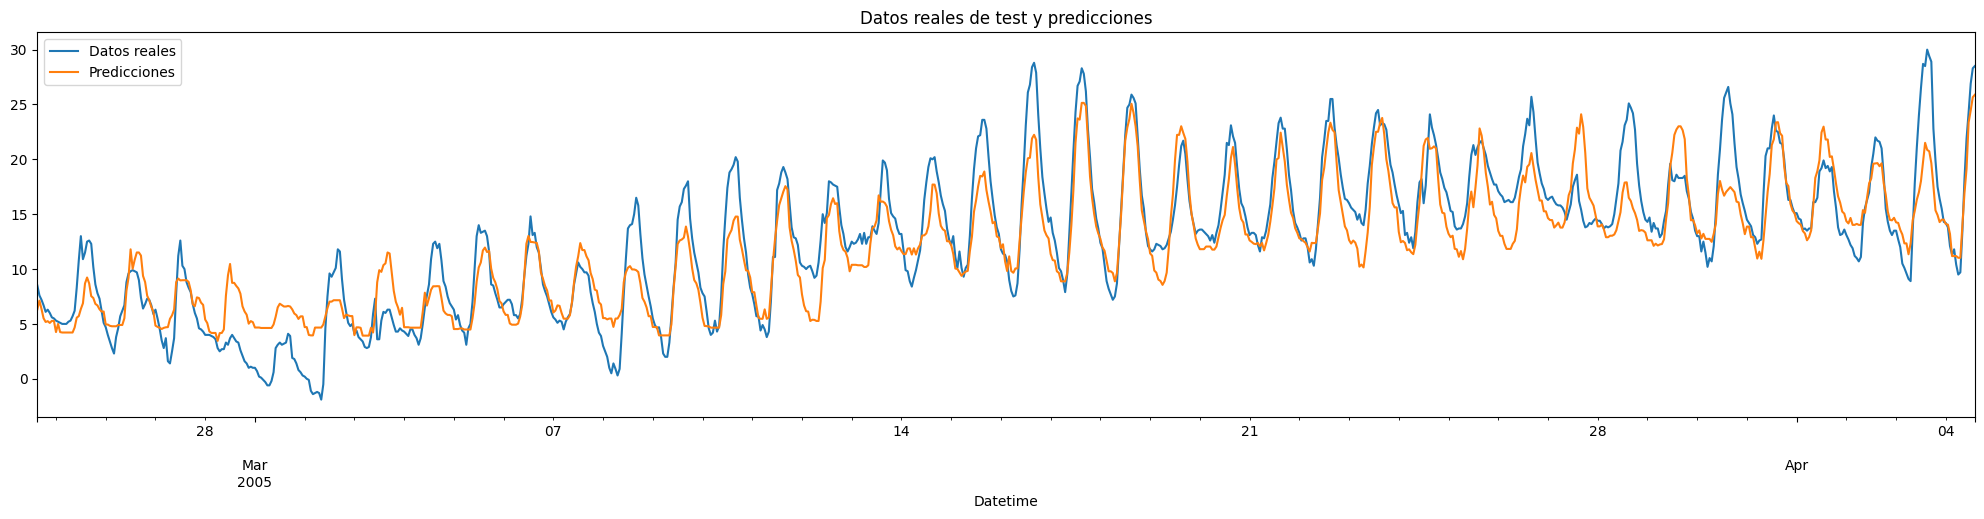

In [ ]:
#Gráfica
ax = val.loc[(val.index >= '2005-02-24 15:00:00')]['T'].plot(figsize=(25, 5), title='Datos reales de test y predicciones')
val.loc[(val.index >= '2005-02-24 15:00:00')]['prediction'].plot()
plt.legend(['Datos reales','Predicciones'])
plt.show()

In [ ]:
# Métriccas
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
score = np.sqrt(mean_squared_error(y_val, y_pred))

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 8.015181600036655
Mean Absolute Error (MAE): 2.219468195418007
Root Mean Squared Error (RMSE): 2.8311096057971077
RMSE Score on Test set: 2.83


*Modelo 2*:

Se prueba un Modelo con menos estimadores (n_Estimadores=500)


In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):   #se usa cross validation
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    FEATURES = ['dayofyear', 'hour', 'dayofweek','quarter', 'month','year',
                'lag_24','lag_168','lag_720']
    TARGET = 'T'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #modelado basado en árboles
                           n_estimators= 500, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:squarederror', #Para hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01)


    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)


[0]	validation_0-rmse:7.64299	validation_1-rmse:4.88643
[100]	validation_0-rmse:4.05666	validation_1-rmse:3.41892
[200]	validation_0-rmse:3.09328	validation_1-rmse:3.15583
[300]	validation_0-rmse:2.81225	validation_1-rmse:3.10123
[400]	validation_0-rmse:2.68580	validation_1-rmse:3.00189
[499]	validation_0-rmse:2.60710	validation_1-rmse:2.95639
[0]	validation_0-rmse:7.23938	validation_1-rmse:10.37351
[100]	validation_0-rmse:3.91165	validation_1-rmse:6.12543
[200]	validation_0-rmse:3.03013	validation_1-rmse:5.06624
[300]	validation_0-rmse:2.76711	validation_1-rmse:4.74033
[400]	validation_0-rmse:2.66616	validation_1-rmse:4.64805
[499]	validation_0-rmse:2.59893	validation_1-rmse:4.74325
[0]	validation_0-rmse:7.64104	validation_1-rmse:11.73128
[100]	validation_0-rmse:4.04669	validation_1-rmse:6.32040
[200]	validation_0-rmse:3.09573	validation_1-rmse:4.43416
[300]	validation_0-rmse:2.82628	validation_1-rmse:3.84448
[400]	validation_0-rmse:2.72141	validation_1-rmse:3.60237
[499]	validation_0

In [ ]:
#promedio de la puntuacion en cada folds
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3.5217
Fold scores:[2.95639129461872, 4.743250434782536, 3.514758752310254, 3.569314720009745, 2.825027817001853]


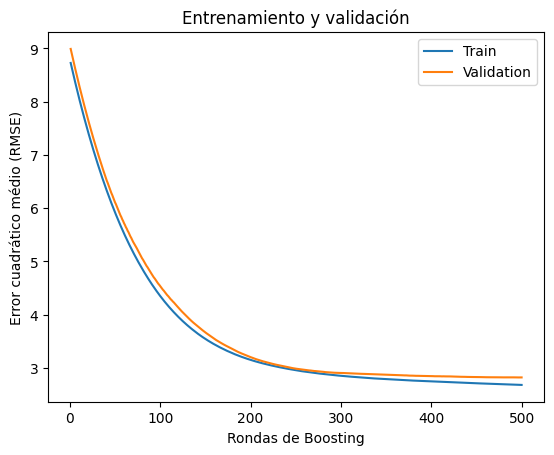

In [ ]:
# Curva train y validacion según la métrica RMSE
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Rondas de Boosting')
plt.ylabel('Error cuadrático médio (RMSE)')
plt.title('Entrenamiento y validación')
plt.legend()
plt.show()

In [ ]:
# Métriccas
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
score = np.sqrt(mean_squared_error(y_val, y_pred))

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 7.980782166834254
Mean Absolute Error (MAE): 2.1907384989608047
Root Mean Squared Error (RMSE): 2.825027817001853
RMSE Score on Test set: 2.83


El Modelo es bastante similar, podemos seguir probando con la minima cantidad de estimadores.

*Modelo 3*

Ahora se prueba con menos features (sacando 'month' y 'quarter')

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):   #se usa cross validation
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    FEATURES = ['dayofyear', 'hour', 'dayofweek','year',
                'lag_24','lag_168','lag_720']
    TARGET = 'T'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #modelado basado en árboles
                           n_estimators= 500, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:squarederror', #Para hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01)


    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)


[0]	validation_0-rmse:7.64299	validation_1-rmse:4.88643
[100]	validation_0-rmse:4.05666	validation_1-rmse:3.41892
[200]	validation_0-rmse:3.09328	validation_1-rmse:3.15583
[300]	validation_0-rmse:2.81225	validation_1-rmse:3.10123
[400]	validation_0-rmse:2.68580	validation_1-rmse:3.00189
[499]	validation_0-rmse:2.60710	validation_1-rmse:2.95639
[0]	validation_0-rmse:7.23938	validation_1-rmse:10.37351
[100]	validation_0-rmse:3.91165	validation_1-rmse:6.12543
[200]	validation_0-rmse:3.03013	validation_1-rmse:5.06624
[300]	validation_0-rmse:2.76711	validation_1-rmse:4.74033
[400]	validation_0-rmse:2.66616	validation_1-rmse:4.64805
[499]	validation_0-rmse:2.59893	validation_1-rmse:4.74325
[0]	validation_0-rmse:7.64104	validation_1-rmse:11.73128
[100]	validation_0-rmse:4.04669	validation_1-rmse:6.32040
[200]	validation_0-rmse:3.09573	validation_1-rmse:4.43416
[300]	validation_0-rmse:2.82628	validation_1-rmse:3.84448
[400]	validation_0-rmse:2.72141	validation_1-rmse:3.60237
[499]	validation_0

In [ ]:
#promedio de la puntuacion en cada folds
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3.5204
Fold scores:[2.95639129461872, 4.743250434782536, 3.514758752310254, 3.569314720009745, 2.8180777681003937]


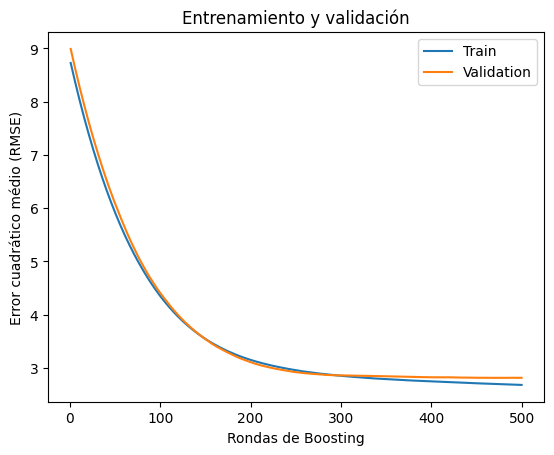

In [ ]:
# Curva train y validacion según la métrica RMSE
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Rondas de Boosting')
plt.ylabel('Error cuadrático médio (RMSE)')
plt.title('Entrenamiento y validación')
plt.legend()
plt.show()

In [ ]:
# Métriccas
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
score = np.sqrt(mean_squared_error(y_val, y_pred))

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 7.941562307061695
Mean Absolute Error (MAE): 2.1855148833022158
Root Mean Squared Error (RMSE): 2.8180777681003937
RMSE Score on Test set: 2.82


*Modelo 4*

No se ha logrado una gran mejoria en los modelos probados (Son todos practicamen te iguales los resultads). Se prueba aumentando el valor de max_depth=10

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):   #se usa cross validation
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    FEATURES = ['dayofyear', 'hour', 'dayofweek','year',
                'lag_24','lag_168','lag_720']
    TARGET = 'T'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #modelado basado en árboles
                           n_estimators= 500, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:squarederror', #Para hacer regresión
                           max_depth=10, #Máxima profundidad de un arbol.
                           learning_rate=0.01)


    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)


[0]	validation_0-rmse:7.63526	validation_1-rmse:4.89644
[100]	validation_0-rmse:3.27422	validation_1-rmse:3.64521
[200]	validation_0-rmse:1.68112	validation_1-rmse:3.36625
[300]	validation_0-rmse:1.06347	validation_1-rmse:3.32044
[400]	validation_0-rmse:0.77638	validation_1-rmse:3.31120
[499]	validation_0-rmse:0.59885	validation_1-rmse:3.35707
[0]	validation_0-rmse:7.23221	validation_1-rmse:10.43504
[100]	validation_0-rmse:3.14926	validation_1-rmse:9.08766
[200]	validation_0-rmse:1.65173	validation_1-rmse:8.42520
[300]	validation_0-rmse:1.06431	validation_1-rmse:8.17800
[400]	validation_0-rmse:0.77876	validation_1-rmse:8.26597
[499]	validation_0-rmse:0.63039	validation_1-rmse:8.21988
[0]	validation_0-rmse:7.63424	validation_1-rmse:11.72892
[100]	validation_0-rmse:3.30738	validation_1-rmse:6.48023
[200]	validation_0-rmse:1.74093	validation_1-rmse:4.86255
[300]	validation_0-rmse:1.14639	validation_1-rmse:4.27270
[400]	validation_0-rmse:0.85659	validation_1-rmse:4.05029
[499]	validation_0

In [ ]:
#promedio de la puntuacion en cada folds
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 4.7594
Fold scores:[3.357073441707636, 8.219880158010344, 3.940492114846576, 4.788779043989887, 3.490858460371183]


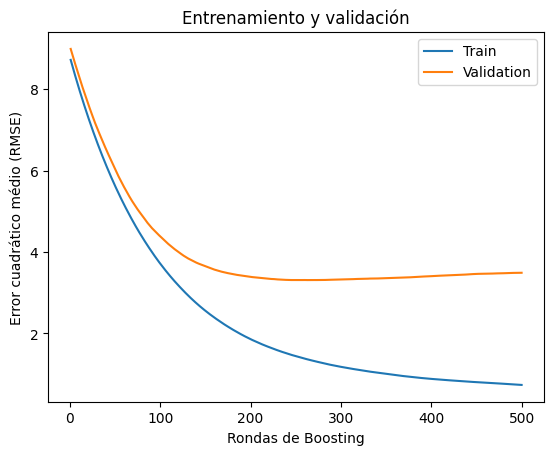

In [ ]:
# Curva train y validacion según la métrica RMSE
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Rondas de Boosting')
plt.ylabel('Error cuadrático médio (RMSE)')
plt.title('Entrenamiento y validación')
plt.legend()
plt.show()

In [ ]:
# Métriccas
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
score = np.sqrt(mean_squared_error(y_val, y_pred))

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 12.186092790345068
Mean Absolute Error (MAE): 2.70734455453025
Root Mean Squared Error (RMSE): 3.490858460371183
RMSE Score on Test set: 3.49


Empeoro mucho el modelo, asi que aumentar la profundidad, no es una buena idea.

*Modelo 5*

Probamos quitando mas features (nos quedamos solo con la mas importante 'dayoftheyear').

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):   #se usa cross validation
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    FEATURES = ['dayofyear',
                'lag_24','lag_168','lag_720']
    TARGET = 'T'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #modelado basado en árboles
                           n_estimators= 500, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:squarederror', #Para hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01)


    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)


[0]	validation_0-rmse:7.64299	validation_1-rmse:4.88643
[100]	validation_0-rmse:4.06983	validation_1-rmse:3.38382
[200]	validation_0-rmse:3.12267	validation_1-rmse:3.13323
[300]	validation_0-rmse:2.87881	validation_1-rmse:3.04778
[400]	validation_0-rmse:2.78222	validation_1-rmse:2.97309
[499]	validation_0-rmse:2.71535	validation_1-rmse:2.91495
[0]	validation_0-rmse:7.23938	validation_1-rmse:10.37351
[100]	validation_0-rmse:3.91835	validation_1-rmse:6.11290
[200]	validation_0-rmse:3.05002	validation_1-rmse:4.91928
[300]	validation_0-rmse:2.82238	validation_1-rmse:4.51020
[400]	validation_0-rmse:2.73070	validation_1-rmse:4.42021
[499]	validation_0-rmse:2.67649	validation_1-rmse:4.33178
[0]	validation_0-rmse:7.64104	validation_1-rmse:11.73128
[100]	validation_0-rmse:4.04870	validation_1-rmse:6.25342
[200]	validation_0-rmse:3.10684	validation_1-rmse:4.34574
[300]	validation_0-rmse:2.86016	validation_1-rmse:3.74686
[400]	validation_0-rmse:2.77233	validation_1-rmse:3.50216
[499]	validation_0

In [ ]:
#promedio de la puntuacion en cada folds
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3.4150
Fold scores:[2.9149495294041423, 4.33178008135263, 3.3930114906325772, 3.5696243367041833, 2.8658810239699455]


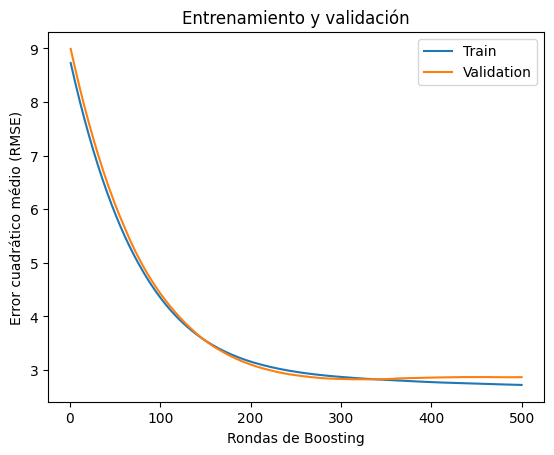

In [ ]:
# Curva train y validacion según la métrica RMSE
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Rondas de Boosting')
plt.ylabel('Error cuadrático médio (RMSE)')
plt.title('Entrenamiento y validación')
plt.legend()
plt.show()

In [ ]:
# Métriccas
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
score = np.sqrt(mean_squared_error(y_val, y_pred))

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 8.213274043551023
Mean Absolute Error (MAE): 2.23392957469337
Root Mean Squared Error (RMSE): 2.8658810239699455
RMSE Score on Test set: 2.87


Empeora levemente. Decidimos quedarnos con 4 features.

*Modelo 6*

Se prueba con un solo lag en lugar de 3.

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):   #se usa cross validation
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    FEATURES = ['dayofyear', 'hour', 'dayofweek','year',
                'lag_24']
    TARGET = 'T'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #modelado basado en árboles
                           n_estimators= 500, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:squarederror', #Para hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01)


    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)


[0]	validation_0-rmse:7.64299	validation_1-rmse:4.88577
[100]	validation_0-rmse:4.09593	validation_1-rmse:3.34005
[200]	validation_0-rmse:3.11383	validation_1-rmse:3.41373
[300]	validation_0-rmse:2.83671	validation_1-rmse:3.41683
[400]	validation_0-rmse:2.72221	validation_1-rmse:3.34391
[499]	validation_0-rmse:2.64448	validation_1-rmse:3.24526
[0]	validation_0-rmse:7.23938	validation_1-rmse:10.37351
[100]	validation_0-rmse:3.94478	validation_1-rmse:6.04558
[200]	validation_0-rmse:3.10823	validation_1-rmse:5.12984
[300]	validation_0-rmse:2.84224	validation_1-rmse:4.79944
[400]	validation_0-rmse:2.73292	validation_1-rmse:4.78856
[499]	validation_0-rmse:2.65735	validation_1-rmse:4.89160
[0]	validation_0-rmse:7.64104	validation_1-rmse:11.73128
[100]	validation_0-rmse:4.07005	validation_1-rmse:6.28606
[200]	validation_0-rmse:3.16269	validation_1-rmse:4.47078
[300]	validation_0-rmse:2.88859	validation_1-rmse:3.89981
[400]	validation_0-rmse:2.77739	validation_1-rmse:3.67986
[499]	validation_0

In [ ]:
#promedio de la puntuacion en cada folds
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3.6114
Fold scores:[3.2452573091730894, 4.891597253093581, 3.490436380788208, 3.6221046756271247, 2.8076060078759277]


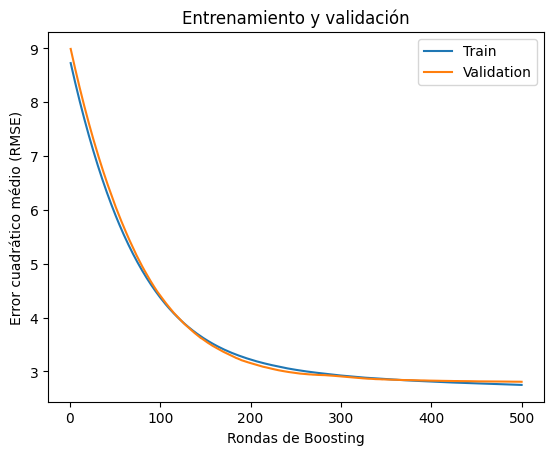

In [ ]:
# Curva train y validacion según la métrica RMSE
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Rondas de Boosting')
plt.ylabel('Error cuadrático médio (RMSE)')
plt.title('Entrenamiento y validación')
plt.legend()
plt.show()

In [ ]:
# Métriccas
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
score = np.sqrt(mean_squared_error(y_val, y_pred))

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 7.882651495461003
Mean Absolute Error (MAE): 2.138590558166178
Root Mean Squared Error (RMSE): 2.8076060078759277
RMSE Score on Test set: 2.81


*Modelo 7*

Debido a que no se logran grandes mejoras, nos quedamos con el Modelo 6 y agregamos las otras dos series temporales como variables.

Se levanta nuevamente el dataset original (paso 1)

In [196]:
print (df)

                        T  C6H6    RH
Datetime                             
2004-03-10 18:00:00  13.6  11.9  48.9
2004-03-10 19:00:00  13.3   9.4  47.7
2004-03-10 20:00:00  11.9   9.0  54.0
2004-03-10 21:00:00  11.0   9.2  60.0
2004-03-10 22:00:00  11.2   6.5  59.6
...                   ...   ...   ...
2005-04-04 10:00:00  21.9  13.5  29.3
2005-04-04 11:00:00  24.3  11.4  23.7
2005-04-04 12:00:00  26.9  12.4  18.3
2005-04-04 13:00:00  28.3   9.5  13.5
2005-04-04 14:00:00  28.5  11.9  13.1

[9357 rows x 3 columns]


In [197]:
#Se usa la función TimeSeriesSplit para la separación de los datos para el cross validatio
tss = TimeSeriesSplit(n_splits=5, test_size=936, gap=24) #Se deja un gap de24 hs entre cada unos de los 5 grupos de datos
df = df.sort_index() # ordena las filas del DataFrame df según los valores del índice

In [198]:
#Cross validation manteniendo el orden temporal de los datos

for i, (train_index, test_index) in enumerate(tss.split(df)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[   0    1    2 ... 4650 4651 4652]
  Test:  index=[4677 4678 4679 4680 4681 4682 4683 4684 4685 4686 4687 4688 4689 4690
 4691 4692 4693 4694 4695 4696 4697 4698 4699 4700 4701 4702 4703 4704
 4705 4706 4707 4708 4709 4710 4711 4712 4713 4714 4715 4716 4717 4718
 4719 4720 4721 4722 4723 4724 4725 4726 4727 4728 4729 4730 4731 4732
 4733 4734 4735 4736 4737 4738 4739 4740 4741 4742 4743 4744 4745 4746
 4747 4748 4749 4750 4751 4752 4753 4754 4755 4756 4757 4758 4759 4760
 4761 4762 4763 4764 4765 4766 4767 4768 4769 4770 4771 4772 4773 4774
 4775 4776 4777 4778 4779 4780 4781 4782 4783 4784 4785 4786 4787 4788
 4789 4790 4791 4792 4793 4794 4795 4796 4797 4798 4799 4800 4801 4802
 4803 4804 4805 4806 4807 4808 4809 4810 4811 4812 4813 4814 4815 4816
 4817 4818 4819 4820 4821 4822 4823 4824 4825 4826 4827 4828 4829 4830
 4831 4832 4833 4834 4835 4836 4837 4838 4839 4840 4841 4842 4843 4844
 4845 4846 4847 4848 4849 4850 4851 4852 4853 4854 4855 4856 4857 4858
 48

In [199]:
#Creación de features basadas en el índice tiempo para captar las estacionalidades

def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour #almacena en una columna nueva la hora
    df['dayofweek'] = df.index.dayofweek #almacena en una columna nueva el día de la semana
    df['year'] = df.index.year #año
    df['dayofyear'] = df.index.dayofyear #dia del año: de 1 a 365
    return df


In [200]:
df = create_features(df)
print(df.head(5))

                        T  C6H6    RH  hour  dayofweek  year  dayofyear
Datetime                                                               
2004-03-10 18:00:00  13.6  11.9  48.9    18          2  2004         70
2004-03-10 19:00:00  13.3   9.4  47.7    19          2  2004         70
2004-03-10 20:00:00  11.9   9.0  54.0    20          2  2004         70
2004-03-10 21:00:00  11.0   9.2  60.0    21          2  2004         70
2004-03-10 22:00:00  11.2   6.5  59.6    22          2  2004         70


In [201]:
#Agregado de lags ayuda a captar la estacionaliad
def add_lags(df):
    df['lag_24'] = df['T'].shift(24) #estacionalidad de 1 día
    df['lag_168'] = df['T'].shift(168) #estacionalidad de 7 días
    df['lag_720'] = df['T'].shift(720) #estacionalidad de 20 días

    return df

# Aplicar la función al DataFrame
df = add_lags(df)
print(df.tail(5))

                        T  C6H6    RH  hour  dayofweek  year  dayofyear  \
Datetime                                                                  
2005-04-04 10:00:00  21.9  13.5  29.3    10          0  2005         94   
2005-04-04 11:00:00  24.3  11.4  23.7    11          0  2005         94   
2005-04-04 12:00:00  26.9  12.4  18.3    12          0  2005         94   
2005-04-04 13:00:00  28.3   9.5  13.5    13          0  2005         94   
2005-04-04 14:00:00  28.5  11.9  13.1    14          0  2005         94   

                     lag_24  lag_168  lag_720  
Datetime                                       
2005-04-04 10:00:00    21.1     17.8     10.0  
2005-04-04 11:00:00    24.0     20.8     13.0  
2005-04-04 12:00:00    26.5     21.6     14.0  
2005-04-04 13:00:00    28.7     23.1     13.3  
2005-04-04 14:00:00    28.5     23.6     13.4  


In [202]:
df = df.sort_index()

In [203]:
tss = TimeSeriesSplit(n_splits=5, test_size=936, gap=24)

In [204]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    FEATURES = ['dayofyear', 'hour', 'dayofweek','year','C6H6','RH',
                'lag_24','lag_168','lag_720'] #se agrega C6H6 y RH como variables exogenas
    TARGET = 'T'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree',
                           n_estimators=500,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

[0]	validation_0-rmse:7.64152	validation_1-rmse:4.88079
[100]	validation_0-rmse:3.76086	validation_1-rmse:2.94453
[200]	validation_0-rmse:2.43918	validation_1-rmse:2.68692
[300]	validation_0-rmse:2.02800	validation_1-rmse:2.55821
[400]	validation_0-rmse:1.85381	validation_1-rmse:2.46125
[499]	validation_0-rmse:1.76239	validation_1-rmse:2.37563
[0]	validation_0-rmse:7.23844	validation_1-rmse:10.37782
[100]	validation_0-rmse:3.67381	validation_1-rmse:6.45371
[200]	validation_0-rmse:2.46585	validation_1-rmse:5.70663
[300]	validation_0-rmse:2.07425	validation_1-rmse:5.40963
[400]	validation_0-rmse:1.91102	validation_1-rmse:5.23587
[499]	validation_0-rmse:1.82217	validation_1-rmse:5.19315
[0]	validation_0-rmse:7.64043	validation_1-rmse:11.73128
[100]	validation_0-rmse:3.89938	validation_1-rmse:6.45734
[200]	validation_0-rmse:2.71420	validation_1-rmse:4.52373
[300]	validation_0-rmse:2.30347	validation_1-rmse:3.83111
[400]	validation_0-rmse:2.13957	validation_1-rmse:3.55986
[499]	validation_0

In [205]:
#promedio de la puntuacion en cada folds
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3.6184
Fold scores:[2.3756284541878343, 5.193152270863008, 3.4580013284331326, 4.542590438652423, 2.5223944952389568]


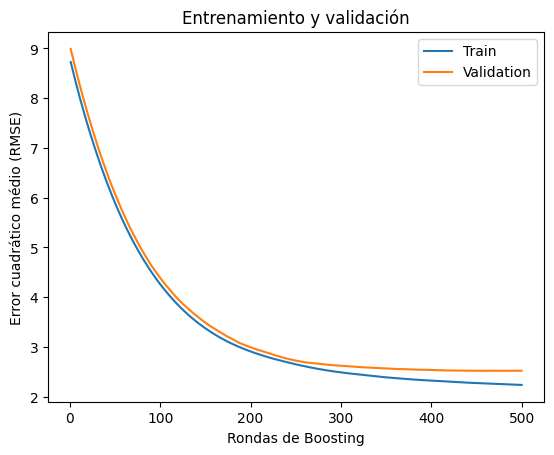

In [206]:
# Curva train y validacion según la métrica RMSE
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Rondas de Boosting')
plt.ylabel('Error cuadrático médio (RMSE)')
plt.title('Entrenamiento y validación')
plt.legend()
plt.show()

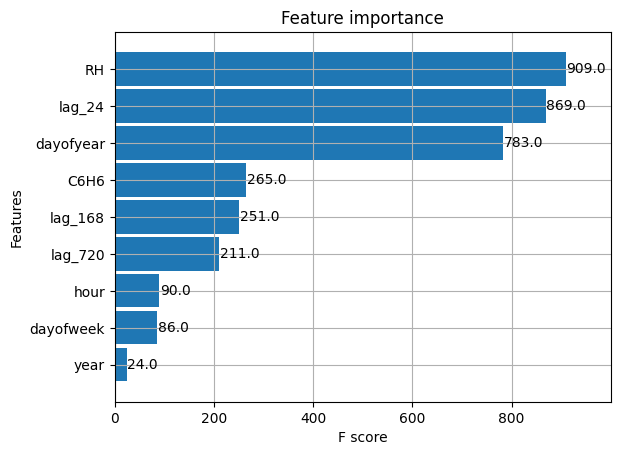

In [207]:
#Importancia de las variables
_ = plot_importance(reg, height=0.9)

In [208]:
# Métriccas
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
score = np.sqrt(mean_squared_error(y_val, y_pred))

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 6.362473989611792
Mean Absolute Error (MAE): 1.9754884522185368
Root Mean Squared Error (RMSE): 2.5223944952389568
RMSE Score on Test set: 2.52


Mejora levemente el modelo al agregar las variables de C6H6 y RH como variables exogenas.

In [209]:
val['prediction'] = reg.predict(X_val)
val

<ipython-input-209-703062ed108f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


,T,C6H6,RH,hour,dayofweek,year,dayofyear,lag_24,lag_168,lag_720,prediction
Datetime,,,,,,,,,,,
2005-02-24 15:00:00,8.5,10.7,66.3,15,3,2005,55,5.6,8.9,4.5,6.133223
2005-02-24 16:00:00,7.6,13.3,70.8,16,3,2005,55,5.4,9.0,5.1,6.060047
2005-02-24 17:00:00,7.2,13.2,72.4,17,3,2005,55,4.9,9.3,5.0,5.353911
2005-02-24 18:00:00,6.7,17.5,74.2,18,3,2005,55,4.8,8.4,4.3,5.131666
2005-02-24 19:00:00,6.1,17.7,75.8,19,3,2005,55,4.8,7.6,4.3,4.667797
...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,21.9,13.5,29.3,10,0,2005,94,21.1,17.8,10.0,21.742996
2005-04-04 11:00:00,24.3,11.4,23.7,11,0,2005,94,24.0,20.8,13.0,27.271534
2005-04-04 12:00:00,26.9,12.4,18.3,12,0,2005,94,26.5,21.6,14.0,28.275154


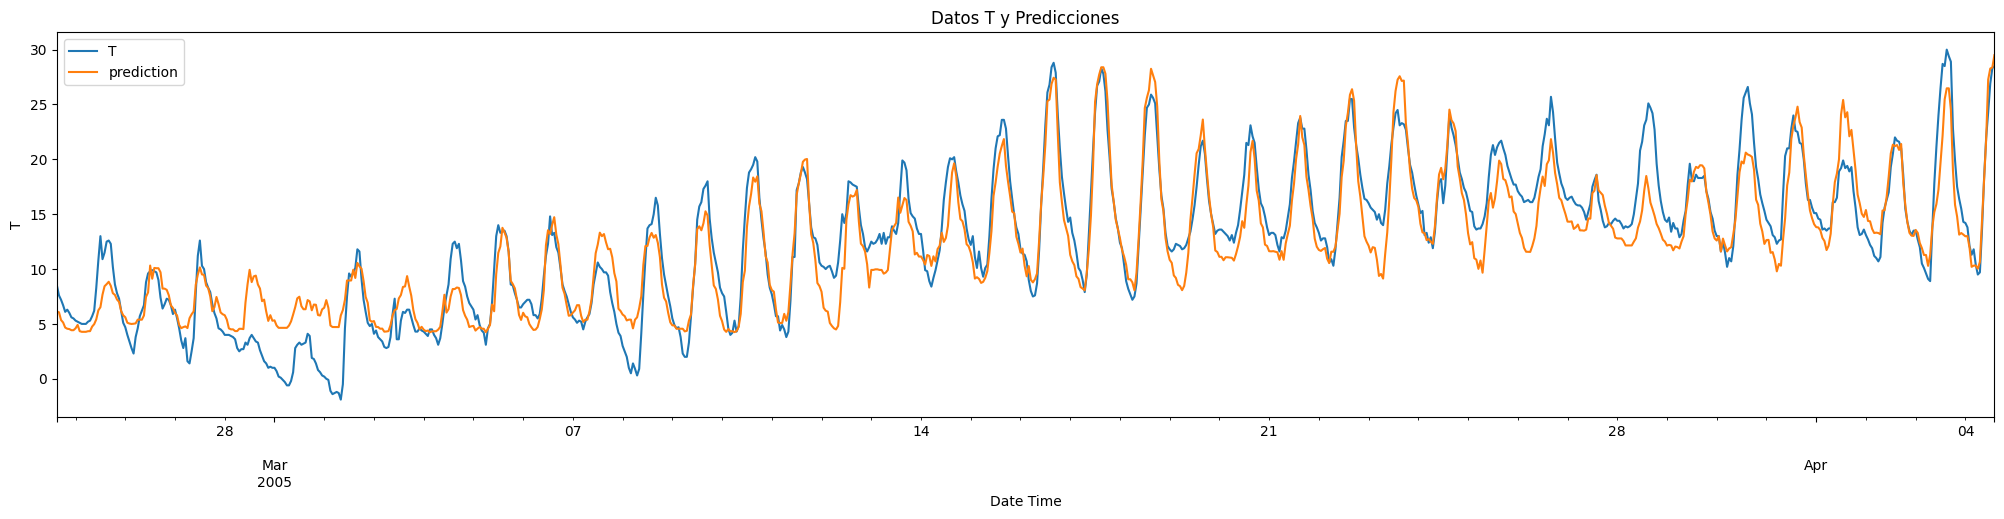

In [210]:
#Gráfica
ax = val.loc[(val.index >= '2005-02-24 15:00:00')]['T'].plot(figsize=(25, 5), title='Datos reales de test y predicciones')
val.loc[(val.index >= '2005-02-24 15:00:00')]['prediction'].plot()
plt.legend(['Datos reales','Predicciones'])

plt.title('Datos T y Predicciones')
plt.legend()

plt.xlabel('Date Time')
plt.ylabel('T')

plt.show()

In [211]:
val['prediction'] = reg.predict(X_val )
val

<ipython-input-211-0912667ba041>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val )


,T,C6H6,RH,hour,dayofweek,year,dayofyear,lag_24,lag_168,lag_720,prediction
Datetime,,,,,,,,,,,
2005-02-24 15:00:00,8.5,10.7,66.3,15,3,2005,55,5.6,8.9,4.5,6.133223
2005-02-24 16:00:00,7.6,13.3,70.8,16,3,2005,55,5.4,9.0,5.1,6.060047
2005-02-24 17:00:00,7.2,13.2,72.4,17,3,2005,55,4.9,9.3,5.0,5.353911
2005-02-24 18:00:00,6.7,17.5,74.2,18,3,2005,55,4.8,8.4,4.3,5.131666
2005-02-24 19:00:00,6.1,17.7,75.8,19,3,2005,55,4.8,7.6,4.3,4.667797
...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,21.9,13.5,29.3,10,0,2005,94,21.1,17.8,10.0,21.742996
2005-04-04 11:00:00,24.3,11.4,23.7,11,0,2005,94,24.0,20.8,13.0,27.271534
2005-04-04 12:00:00,26.9,12.4,18.3,12,0,2005,94,26.5,21.6,14.0,28.275154


In [228]:
train['prediction'] = reg.predict(X_train)
train

<ipython-input-228-588bb2489198>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['prediction'] = reg.predict(X_train)


,T,C6H6,RH,hour,dayofweek,year,dayofyear,lag_24,lag_168,lag_720,prediction
Datetime,,,,,,,,,,,
2004-03-10 18:00:00,13.6,11.9,48.9,18,2,2004,70,NaN,NaN,NaN,11.316076
2004-03-10 19:00:00,13.3,9.4,47.7,19,2,2004,70,NaN,NaN,NaN,11.369620
2004-03-10 20:00:00,11.9,9.0,54.0,20,2,2004,70,NaN,NaN,NaN,10.604176
2004-03-10 21:00:00,11.0,9.2,60.0,21,2,2004,70,NaN,NaN,NaN,10.475502
2004-03-10 22:00:00,11.2,6.5,59.6,22,2,2004,70,NaN,NaN,NaN,10.207601
...,...,...,...,...,...,...,...,...,...,...,...
2005-02-23 10:00:00,3.1,3.8,83.0,10,2,2005,54,6.1,8.9,8.7,5.343598
2005-02-23 11:00:00,2.8,3.6,83.9,11,2,2005,54,9.1,9.1,10.0,7.233710
2005-02-23 12:00:00,3.9,3.7,79.5,12,2,2005,54,11.4,9.1,11.8,8.235317


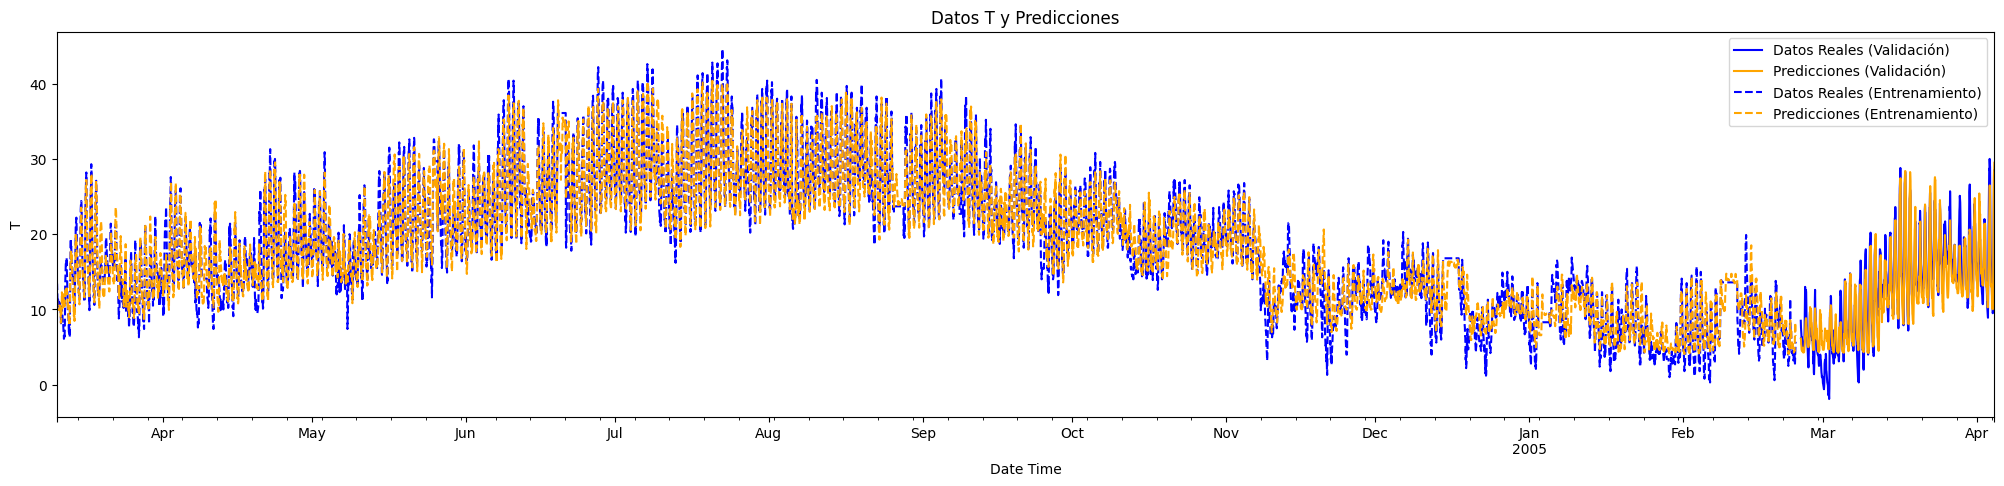

In [213]:
plt.figure(figsize=(25, 5))

# Graficar los datos reales y las predicciones para el DataFrame de validación
ax = val.loc[val.index >= '2005-02-24 15:00:00']['T'].plot(label='Datos Reales (Validación)', color='blue')
val.loc[val.index >= '2005-02-24 15:00:00']['prediction'].plot(ax=ax, label='Predicciones (Validación)', color='orange')

# Graficar los datos reales y las predicciones para el DataFrame de entrenamiento
train.loc[train.index >= '2004-03-10 18:00:00']['T'].plot(ax=ax, label='Datos Reales (Entrenamiento)', color='blue', linestyle='--')
train.loc[train.index >= '2004-03-10 18:00:00']['prediction'].plot(ax=ax, label='Predicciones (Entrenamiento)', color='orange', linestyle='--')

plt.title('Datos T y Predicciones')
plt.legend()

plt.xlabel('Date Time')
plt.ylabel('T')

plt.show()

**Pronosticar las próximas 24 horas**

In [214]:
# Último índice en tus datos
last_index = pd.Timestamp('2005-04-04 14:00:00')

In [215]:
# Data frame vacio con el index para los datos futuros
future_dates = pd.date_range(start=last_index + pd.Timedelta(hours=1), periods=24, freq='H')

In [216]:
future_df = pd.DataFrame(index=future_dates)
future_df.head()

""
2005-04-04 15:00:00
2005-04-04 16:00:00
2005-04-04 17:00:00
2005-04-04 18:00:00
2005-04-04 19:00:00


In [217]:
C6H6_futuro = df['C6H6'].mean()
print(C6H6_futuro)

10.190392219728546


In [218]:
RH_futuro = df['RH'].mean()
print(RH_futuro)

48.817430800470234


In [243]:
#Agregar variables al data frame futuro de 24 horas, simular los lags futuros y estimar un valor  futuro para las variables exógenas

future_df['year'] = future_df.index.year
future_df['dayofweek'] = future_df.index.dayofweek
future_df['dayofyear'] = future_df.index.dayofyear
future_df['hour'] = future_df.index.hour

future_df['C6H6'] = 10
future_df['RH'] = 48
future_df['lag_24'] = future_df['C6H6']  # Simular valores para lag_24
future_df['lag_168'] = future_df['C6H6']  # Simular valores para lag_168
future_df['lag_720'] = future_df['C6H6']  # Simular valores para lag_720



In [241]:
# Ordenar las columnas para que coincidan con las que espera el modelo
feature_columns = ['dayofyear', 'hour', 'dayofweek', 'year', 'C6H6', 'RH','lag_24','lag_168', 'lag_720']
future_df = future_df[feature_columns]

In [242]:

future_predictions = reg.predict(future_df)
future_df['prediction'] = future_predictions
future_df


,dayofyear,hour,dayofweek,year,C6H6,RH,lag_24,lag_168,lag_720,prediction
2005-04-04 15:00:00,94,15,0,2005,10,48,10,10,10,11.780357
2005-04-04 16:00:00,94,16,0,2005,10,48,10,10,10,11.780357
2005-04-04 17:00:00,94,17,0,2005,10,48,10,10,10,11.780357
2005-04-04 18:00:00,94,18,0,2005,10,48,10,10,10,11.780357
2005-04-04 19:00:00,94,19,0,2005,10,48,10,10,10,11.780357
2005-04-04 20:00:00,94,20,0,2005,10,48,10,10,10,11.780357
2005-04-04 21:00:00,94,21,0,2005,10,48,10,10,10,11.780357
2005-04-04 22:00:00,94,22,0,2005,10,48,10,10,10,11.780357
2005-04-04 23:00:00,94,23,0,2005,10,48,10,10,10,11.780357
2005-04-05 00:00:00,95,0,1,2005,10,48,10,10,10,11.780357


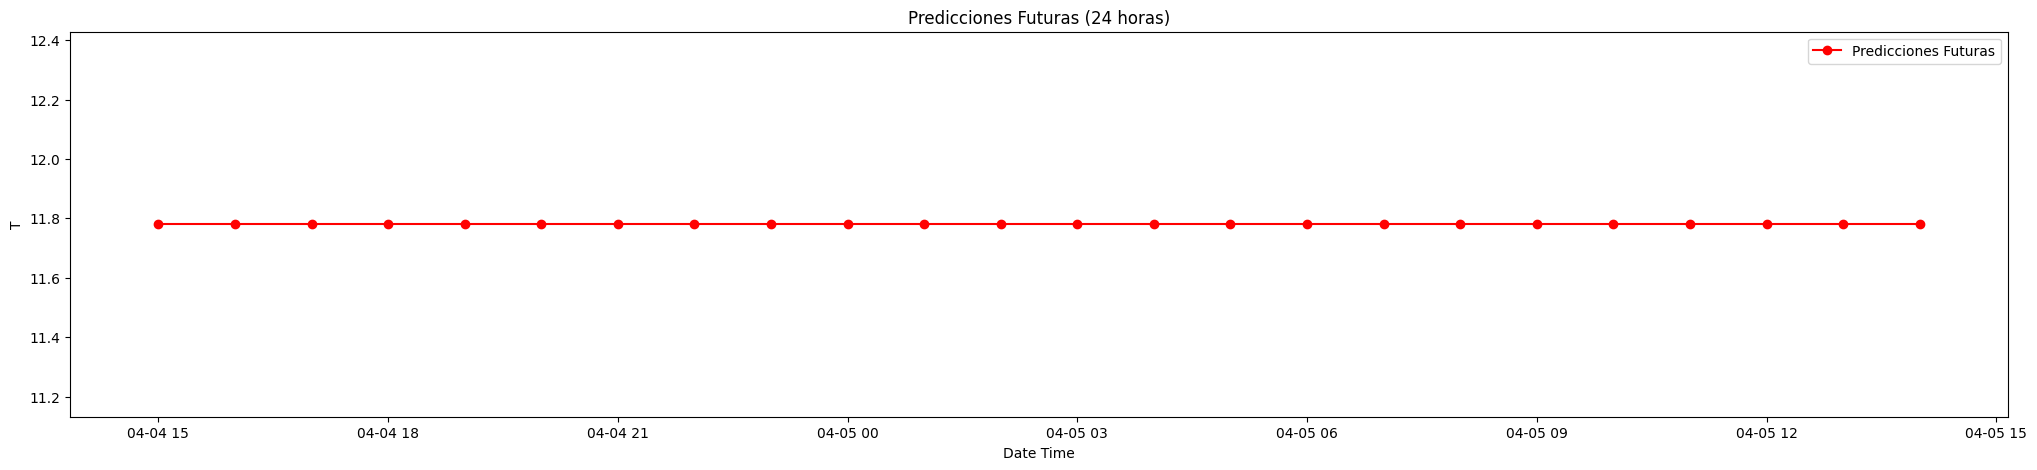

In [ ]:
plt.figure(figsize=(25, 5))

# Graficar predicciones futuras
plt.plot(future_df.index, future_df['prediction'], label='Predicciones Futuras',  color='red', marker='o')

plt.title('Predicciones Futuras (24 horas)')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('T')

# Mostrar el gráfico
plt.show()

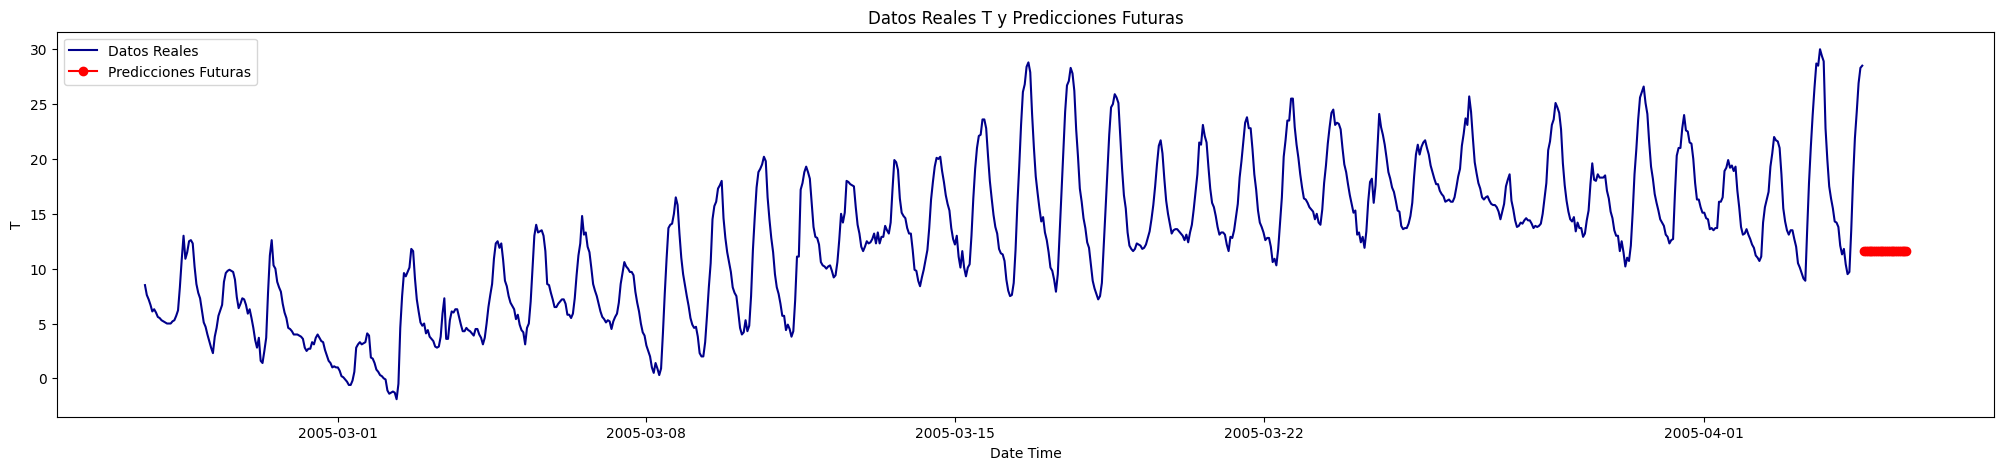

In [ ]:
plt.figure(figsize=(25, 5))

plt.plot(val.index, val['T'], label='Datos Reales', color='darkblue')

# Predicciones futuras
plt.plot(future_df.index, future_df['prediction'], label='Predicciones Futuras',  color='red', marker='o')

# Configurar título y leyenda
plt.title('Datos Reales T y Predicciones Futuras')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('T')

# Mostrar el gráfico
plt.show()